In [1]:
using Flux
using ReinforcementLearning
using StatsBase:mean
using Plots
using Zygote
using LinearAlgebra
using Base.Iterators
using Random
using Colors

┌ Info: CUDAdrv.jl failed to initialize, GPU functionality unavailable (set JULIA_CUDA_SILENT or JULIA_CUDA_VERBOSE to silence or expand this message)
└ @ CUDAdrv /Users/kaitlinmaile/.julia/packages/CUDAdrv/b1mvw/src/CUDAdrv.jl:67


In [2]:
Base.@kwdef mutable struct αsPerEpisode <: AbstractHook
    αs::Vector{Array{Float64}} = Float64[]
    tag::String = "TRAINING"
end

function (hook::αsPerEpisode)(
    ::Union{PostEpisodeStage,PostExperimentStage},
    agent,
    env,
    obs,
)
    push!(hook.αs, softmax(deepcopy(agent.policy.learner.approximator.model.weights)))
    #println(softmax(deepcopy(agent.policy.learner.approximator.model.weights)))
    @debug hook.tag ALPHAS_PER_EPISODE = hook.αs[end]
end

Base.@kwdef mutable struct wsPerEpisode <: AbstractHook
    ws::Vector{Array{Float64}} = Float64[]
    tag::String = "TRAINING"
end


function (hook::wsPerEpisode)(
    ::Union{PostEpisodeStage,PostExperimentStage},
    agent,
    env,
    obs,
)
    flat_ps, re = Flux.destructure(deepcopy(agent.policy.learner.approximator.model))
    push!(hook.ws, flat_ps)
    @debug hook.tag WEIGHTS_PER_EPISODE = hook.ws[end]
end

In [11]:
ConvChain(input, hd1, output) =  Chain(
                    #x -> vcat()
                    Dense(input, hd1, relu),
                    Dense(hd1, output),
                ) 

DenseChain(input, hd1, output) =  Chain(
                    Dense(input, hd1, relu),
                    Dense(hd1, output),
                ) 

DenseChain(input, hd1, hd2, output) =  Chain(
                    Dense(input, hd1, relu),
                    Dense(hd1, hd2, relu),
                    Dense(hd2, output),
                ) 


DenseChain (generic function with 2 methods)

In [4]:
struct MixChain
    weights
    chain_1_1
    chain_4_4
    chain_16_16
    chain_16_64
    chain_128_128
    chain_1024_1024
    chain_1024
end


MixChain(input::Int64, output::Int64, weights) = MixChain(weights, 
                                                         DenseChain(input, 1, 1, output),
                                                         DenseChain(input, 4, 4, output), 
                                                         DenseChain(input, 16, 16, output),
                                                         DenseChain(input, 16, 64, output),
                                                         DenseChain(input, 128, 128, output),
                                                         DenseChain(input, 1024, 1024, output),
                                                         DenseChain(input, 1024, output))

function (m::MixChain)(x)
    mpw = softmax(m.weights)
    c1 = mpw[1]*m.chain_1_1(x)
    c2 = mpw[2]*m.chain_4_4(x)
    c3 = mpw[3]*m.chain_16_16(x)
    c4 = mpw[4]*m.chain_16_64(x)
    c5 = mpw[5]*m.chain_128_128(x)
    c6 = mpw[6]*m.chain_1024_1024(x)
    c7 = mpw[7]*m.chain_1024(x)
    #println(size(id,1),"\t",size(d1),"\t",size(d4))
    #d4[1:size(id,1),:] .+= d1+id
    c1+c2+c3+c4+c5+c6+c7
end

Flux.@functor MixChain

In [5]:
struct MixOp
    weights::Array{Any}
    chains::Array{Any}
end


MixOp(input::Int64, output::Int64, weights) = MixOp(weights,[
                                                         DenseChain(input, 4, 4, output), 
                                                         DenseChain(input, 16, 64, output),
                                                         DenseChain(input, 128, 128, output)
                                                                ])

function (m::MixOp)(x)
    mpw = softmax(m.weights)
    c1 = mpw[1]*m.chains[1](x)
    c2 = mpw[2]*m.chains[2](x)
    c3 = mpw[3]*m.chains[3](x)
    #println(size(id,1),"\t",size(d1),"\t",size(d4))
    #d4[1:size(id,1),:] .+= d1+id
    c1+c2+c3
end

Flux.@functor MixOp

In [6]:
struct DARTSLearner{Q,F,R} <: AbstractLearner
    approximator::Q
    loss_func::F
    γ::Float32
    batch_size::Int
    min_replay_history::Int
    rng::R
    ξ::Float32
end

(learner::DARTSLearner)(obs) =
    obs |> get_state |>
    x ->
        send_to_device(device(learner.approximator), x) |> learner.approximator |>
        send_to_host

function DARTSLearner(;
    approximator::Q,
    loss_func::F,
    γ = 0.99f0,
    batch_size = 32,
    min_replay_history = 32,
    seed = nothing,
    first = false 
) where {Q,F}
    rng = MersenneTwister(seed)
    first ? ξ = 0 : ξ = approximator.optimizer.eta 
    DARTSLearner{Q,F,typeof(rng)}(
        approximator,
        loss_func,
        γ,
        batch_size,
        min_replay_history,
        rng,
        ξ
    )
end

DARTSLearner

In [7]:
function flatten_grads(grads)
    xs = Zygote.Buffer([])
    fmap(grads) do x
        x isa AbstractArray && push!(xs, x)
        #println("x ",x)
        return x
    end
    flat_gs = vcat(vec.(copy(xs))...)
end



function my_update!(opt, ps::Params, gs)
  for (p, g) in zip(ps, gs)
    g == nothing && continue
    Flux.Optimise.update!(opt, p, g)
  end
end

my_update! (generic function with 1 method)

In [8]:
function RLBase.update!(learner::DARTSLearner, batch) 
    Q, γ, loss_func, batch_size =
        learner.approximator, learner.γ, learner.loss_func, learner.batch_size
    s, r, t, s′ = map(
        x -> send_to_device(device(Q), x),
        (batch.state, batch.reward, batch.terminal, batch.next_state),
    )
    a = CartesianIndex.(batch.action, 1:batch_size)
    
    
    function grad(Q_, ps, verbose = false)
        gs = gradient(ps) do
            q = batch_estimate(Q_, s)[a]
            if verbose
                println("q: ", q)
            end
            q′ = vec(maximum(batch_estimate(Q_, s′); dims = 1))
            if verbose
                println("q': ", q')
            end
            G = r .+ γ .* (1 .- t) .* q′
            if verbose
                println("G: ", G)
            end
            loss_func(G, q)
        end
        return gs
    end

    w = params(Q.model.chain_4_4, Q.model.chain_16_64, Q.model.chain_128_128)
    α = params(Q.model.weights)
    gsα = grad(Q, α)
    if learner.ξ != 0
        Q_prime = deepcopy(Q)
        Q_prime_α = deepcopy(Q_prime)
        w_prime = params(Q_prime.model.chain_4_4, Q_prime.model.chain_16_64, Q_prime.model.chain_128_128)

        gsw_prime = grad(Q_prime, w_prime)

        Flux.Optimise.update!(Descent(learner.ξ), w_prime, gsw_prime)

        Q_prime_minus = deepcopy(Q_prime)
        #Q_prime_plus = deepcopy(Q_prime)

        w_prime_minus = params(Q_prime_minus.model.chain_4_4, Q_prime_minus.model.chain_16_64, Q_prime_minus.model.chain_128_128)
        #w_prime_plus = params(Q_prime_plus.model.chain_4_4, Q_prime_plus.model.chain_16_64, Q_prime_plus.model.chain_128_128)

        gsw_prime_minus = grad(Q_prime_minus, w_prime_minus)
        #gsw_prime_plus = grad(Q_prime_plus, w_prime_plus)  #TODO: make this same as gsw_minus

        Q_minus = deepcopy(Q)
        Q_plus = deepcopy(Q)

        w_minus = params(Q_minus.model.chain_4_4, Q_minus.model.chain_16_64, Q_minus.model.chain_128_128)
        w_plus = params(Q_plus.model.chain_4_4, Q_plus.model.chain_16_64, Q_plus.model.chain_128_128)

        epsilon = 0.01 ./ norm([gsw_prime_minus[w] for w in w_prime_minus])

        my_update!(Descent(epsilon), w_minus, [gsw_prime_minus[w] for w in w_prime_minus.order])
        my_update!(Descent(-1*epsilon), w_plus, [gsw_prime_minus[w] for w in w_prime_minus.order])
        
        gsα_prime = grad(Q_prime_α, params(Q_prime_α.model.weights))
        
        gsα_plus = grad(Q_plus, params(Q_plus.model.weights))
        gsα_minus = grad(Q_minus, params(Q_minus.model.weights))
        
        my_update!(Q.optimizer, α, [gsα_prime[a] for a in params(Q_prime_α.model.weights).order])
        
        my_update!(Descent(-1*learner.ξ^2/(2*epsilon)), α, [gsα_plus[a] for a in params(Q_plus.model.weights).order])
        my_update!(Descent(learner.ξ^2/(2*epsilon)), α, [gsα_minus[a] for a in params(Q_minus.model.weights).order])
    else
        Flux.Optimise.update!(Q.optimizer, α, gsα)
    end
    gsw = grad(Q, w)
    Flux.Optimise.update!(Q.optimizer, w, gsw)
end

function RLBase.extract_experience(
    t::CircularCompactSARTSATrajectory,
    learner::DARTSLearner,
)
    if length(t) > learner.min_replay_history
        inds = rand(learner.rng, 1:length(t), learner.batch_size)
        map(get_trace(t, :state, :action, :reward, :terminal, :next_state)) do x
            consecutive_view(x, inds)
        end
    else
        nothing
    end
end

In [141]:
function my_update!(opt, ps::Params, gs)
  for (p, g) in zip(ps, gs)
    g == nothing && continue
    Flux.Optimise.update!(opt, p, g)
  end
end

function params_(chains)
    ps = Params()
    for chain in chains
        Flux.params!(ps,chain)
    end
    return ps
end

function RLBase.update!(learner::DARTSLearner, batch) 
    Q, γ, loss_func, batch_size =
        learner.approximator, learner.γ, learner.loss_func, learner.batch_size
    s, r, t, s′ = map(
        x -> send_to_device(device(Q), x),
        (batch.state, batch.reward, batch.terminal, batch.next_state),
    )
    a = CartesianIndex.(batch.action, 1:batch_size)
    
    
    function grad(Q_, ps, verbose = false)
        gs = gradient(ps) do
            q = batch_estimate(Q_, s)[a]
            if verbose
                println("q: ", q)
            end
            q′ = vec(maximum(batch_estimate(Q_, s′); dims = 1))
            if verbose
                println("q': ", q')
            end
            G = r .+ γ .* (1 .- t) .* q′
            if verbose
                println("G: ", G)
            end
            loss_func(G, q)
        end
        return gs
    end

    w = params_(Q.model.chains)
    α = params(Q.model.weights)
    gsα = grad(Q, α)
    if learner.ξ != 0
        Q_prime = deepcopy(Q)
        Q_prime_α = deepcopy(Q_prime)
        w_prime = params_(Q_prime.model.chains)

        gsw_prime = grad(Q_prime, w_prime)

        Flux.Optimise.update!(Descent(learner.ξ), w_prime, gsw_prime)

        Q_prime_minus = deepcopy(Q_prime)

        w_prime_minus = params_(Q_prime_minus.model.chains)

        gsw_prime_minus = grad(Q_prime_minus, w_prime_minus)

        Q_minus = deepcopy(Q)
        Q_plus = deepcopy(Q)

        w_minus = params_(Q_minus.model.chains)
        w_plus = params_(Q_plus.model.chains)

        epsilon = 0.01 ./ norm([gsw_prime_minus[w] for w in w_prime_minus.order if gsw_prime_minus[w] != nothing])
        my_update!(Descent(epsilon), w_minus, [gsw_prime_minus[w] for w in w_prime_minus.order])
        my_update!(Descent(-1*epsilon), w_plus, [gsw_prime_minus[w] for w in w_prime_minus.order])
        
        gsα_prime = grad(Q_prime_α, params(Q_prime_α.model.weights))
        
        gsα_plus = grad(Q_plus, params(Q_plus.model.weights))
        gsα_minus = grad(Q_minus, params(Q_minus.model.weights))
                        
        for a in params(Q_prime_α.model.weights).order
            println(a, " gsα_prime ", gsα_prime[a])
        end
                        
        for a in params(Q_plus.model.weights).order
            println(gsα_plus[a])                
        end
                        
        my_update!(Q.optimizer, α, [gsα_prime[a] for a in params(Q_prime_α.model.weights).order])
        
        my_update!(Descent(-1*learner.ξ^2/(2*epsilon)), α, [gsα_plus[a] for a in params(Q_plus.model.weights).order])
        my_update!(Descent(learner.ξ^2/(2*epsilon)), α, [gsα_minus[a] for a in params(Q_minus.model.weights).order])
    else
        Flux.Optimise.update!(Q.optimizer, α, gsα)
    end
    gsw = grad(Q, w)
    Flux.Optimise.update!(Q.optimizer, w, gsw)
end

function RLBase.extract_experience(
    t::CircularCompactSARTSATrajectory,
    learner::DARTSLearner,
)
    if length(t) > learner.min_replay_history
        inds = rand(learner.rng, 1:length(t), learner.batch_size)
        map(get_trace(t, :state, :action, :reward, :terminal, :next_state)) do x
            consecutive_view(x, inds)
        end
    else
        nothing
    end
end

In [9]:
function train(;first_order = false) 
    env = CartPoleEnv(; T = Float32, seed = 11)
    ns, na = length(rand(get_observation_space(env))), length(get_action_space(env))
    Random.seed!(11)
    agent = Agent(
        policy = QBasedPolicy(
            learner = DARTSLearner(
                approximator = NeuralNetworkApproximator(
                    model = MixChain(ns,na,rand(7)),
                    optimizer = ADAM(),
                ),
                batch_size = 32,
                min_replay_history = 100,
                loss_func = huber_loss,
                seed = 22,
                first = first_order
            ),
            explorer = EpsilonGreedyExplorer(
                kind = :exp,
                ϵ_stable = 0.01,
                decay_steps = 500,
                seed = 33,
            ),
        ),
        trajectory = CircularCompactSARTSATrajectory(
            capacity = 1000,
            state_type = Float32,
            state_size = (ns,),
        ),
    )
    hook = ComposedHook(TotalRewardPerEpisode(), TimePerStep(), αsPerEpisode(), wsPerEpisode())
    run(agent, env, StopAfterStep(200), hook)
    return hook
end

train (generic function with 1 method)

In [12]:
hook_2 = train(first_order=false)
hook_1 = train(first_order=true)


Progress: 100%|█████████████████████████████████████████| Time: 3:07:02
Progress: 100%|█████████████████████████████████████████| Time: 0:53:26


ComposedHook{Tuple{TotalRewardPerEpisode,TimePerStep,αsPerEpisode,wsPerEpisode}}((TotalRewardPerEpisode([13.0, 9.0, 18.0, 39.0, 11.0, 10.0, 20.0, 52.0, 19.0], 0.0, "TRAINING"), TimePerStep([0.000139571, 32.125347235, 32.140804712, 31.292704114, 32.452060699, 30.223937294, 63.863975134, 31.383885663, 31.535899636, 28.241514841  …  27.723211262, 28.600431687, 30.324938473, 26.993083823, 31.487293456, 30.460366481, 26.695556443, 29.085628431, 30.059646267, 26.468384795], 0x0000fe0dbbb05a82), αsPerEpisode(Array{Float64,N} where N[[0.12449457991272513, 0.1386629042510924, 0.19567188251923154, 0.15617062230588513, 0.1160845450877947, 0.12066356581916313, 0.14825190010410794], [0.12449457991272513, 0.1386629042510924, 0.19567188251923154, 0.15617062230588513, 0.1160845450877947, 0.12066356581916313, 0.14825190010410794], [0.12449457991272513, 0.1386629042510924, 0.19567188251923154, 0.15617062230588513, 0.1160845450877947, 0.12066356581916313, 0.14825190010410794], [0.12449457991272513, 0.138

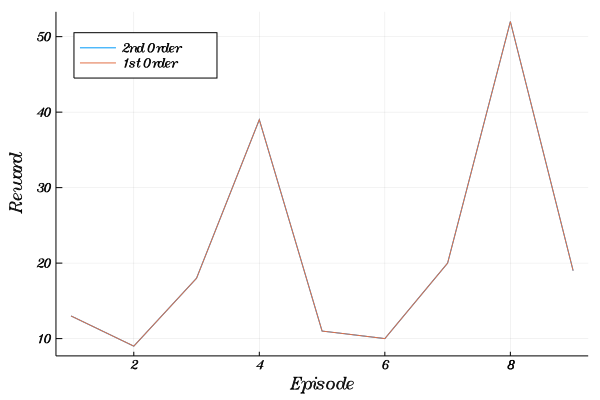

In [13]:
plot(hook_2[1].rewards, xlabel="Episode", ylabel="Reward", label="2nd Order",legend=:topleft)
plot!(hook_1[1].rewards, label="1st Order")

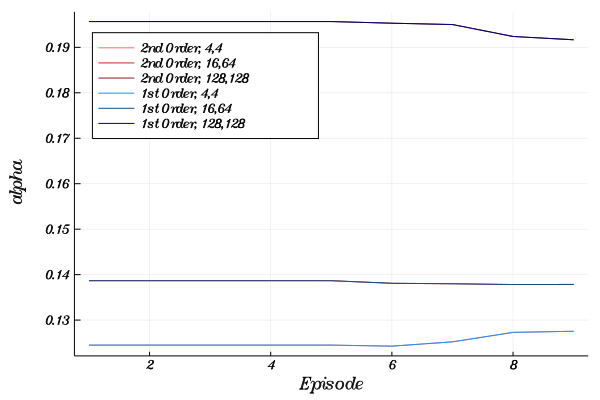

In [14]:
plot([α[1] for α in hook_2[3].αs], color=:indianred1, xlabel="Episode", ylabel="alpha", label="2nd Order, 4,4",legend=:topleft)
plot!([α[2] for α in hook_2[3].αs], color=:firebrick3, label="2nd Order, 16,64")
plot!([α[3] for α in hook_2[3].αs], color=:firebrick4, label="2nd Order, 128,128")
plot!([α[1] for α in hook_1[3].αs], color=:dodgerblue1, label="1st Order, 4,4")
plot!([α[2] for α in hook_1[3].αs], color=:dodgerblue4, label="1st Order, 16,64")
plot!([α[3] for α in hook_1[3].αs], color=:navyblue, label="1st Order, 128,128")

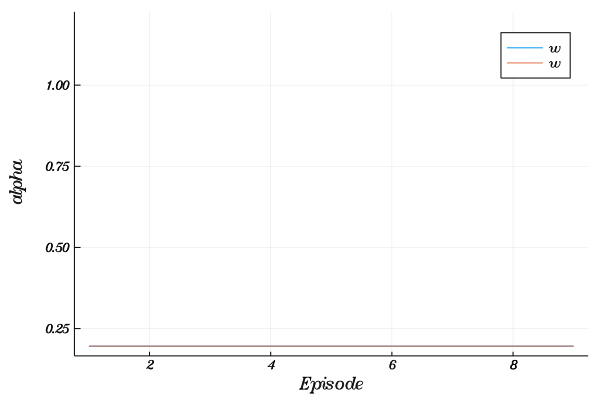

In [15]:
plot([w[10] for w in hook_2[4].ws], xlabel="Episode", ylabel="alpha", label="w")
plot!([w[10] for w in hook_1[4].ws], xlabel="Episode", ylabel="alpha", label="w")